# **Parallel MergeSort**

<h4><i>Phần thư viện

Đầu tiên ta import các thư viện cần thiết như 
* `time`: dùng để tính thời gian thực thi
* `random`: dùng để random ra dữ liệu input
* `multiprocessing`: dùng để chạy song song trên các CPU khác nhau

In [2]:
from multiprocessing import Pool
import multiprocessing
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns

<h4><i> Phần MergeSort

Ở phần này ta sẽ cần hai hàm đó là `merge` và `mergeSort`, hai hàm này giống như mergeSort bình thường

Nhắc lại thuật toán `mergeSort`:
* Thuật toán này dựa trên ý tưởng chia để trị `Divide and Conquer`
* Nếu thuật toán `mergeSort` này chạy đơn luồng thì thuật toán này có độ phức tạp về thời gian là `O(nlogn)` và thuật toán này có độ phức tạp về không gian là `O(n)` (**Ở PYTHON TA KHÔNG CẦN XOÁ NHỮNG MẢNG CON NHƯ Ở C++, ĐIỀU ĐÓ LÀ BỞI PYTHON SẼ TỰ THU HỒI VÙNG NHỚ**)


**`MERGE`**
* Hàm merge dùng để trộn hai mảng con, nó sẽ so sánh từng đôi một giá trị của hai mảng cho đến khi một trong hai mảng hoặc cả hai mảng hết không còn giá trị, sau đó gộp mảng còn lại (hoặc dừng lại nếu cả hai mảng hết phần tử) vào mảng đích
* `Hàm này nhận giá trị đầu vào là hai mảng con và trả về một mảng đích đã được sắp xếp`

In [2]:
def merge(*args):
    left, right = args[0] if len(args) == 1 else args
    left_length, right_length = len(left), len(right)
    left_index, right_index = 0, 0
    merged = []
    while left_index < left_length and right_index < right_length:
        if left[left_index] <= right[right_index]:
            merged.append(left[left_index])
            left_index += 1
        else:
            merged.append(right[right_index])
            right_index += 1
    if left_index == left_length:
        merged.extend(right[right_index:])
    else:
        merged.extend(left[left_index:])
    return merged

**`MERGESORT`**
* Chia để trị của thuật toán nằm ở phần hàm này, hàm này sẽ chia mảng thành hai phần bằng nhau hoặc hơn kém nhau 1 đơn vị
* Sau đó ta lại đệ quy chia 2 mảng con vừa chia thành nhiều mảng con nhỏ hơn
* Cho đến cuối cùng khi mảng con chỉ còn 1 phần tử thì thuật toán sẽ kết thúc phần đệ quy ở đó và sẽ quay lại chạy đệ quy những tầng trên (mảng có 2 phân tử)
* Ta sẽ thực hiện `merge`
* Cho đến cuối cùng ta sẽ nhận được một mảng mới đã sắp xếp
* `Hàm này nhận vào một mảng bất kì và sẽ trả về một mảng đã được sắp xếp`

In [3]:
def merge_sort(data):
    length = len(data)
    if length <= 1:
        return data
    middle = length // 2
    left = merge_sort(data[:middle])
    right = merge_sort(data[middle:])
    return merge(left, right)

<h4><i> Phần parallel

Phần này mới là `thuật toán song song` còn phần trên chỉ là `merge sort` cổ điển

In [4]:
def merge_sort_parallel(arr, num_processes):
    if len(arr) < num_processes:
        num_processes = len(arr)  # Chỉ sử dụng số tiến trình bằng số phần tử nếu dãy quá nhỏ
    chunk_size = len(arr) // num_processes

    # Chia dãy thành các phần nhỏ
    chunks = [arr[i:i + chunk_size] for i in range(0, len(arr), chunk_size)]

    # Sắp xếp các phần nhỏ bằng các tiến trình riêng biệt
    with multiprocessing.Pool(num_processes) as pool:
        sorted_chunks = pool.map(merge_sort, chunks)

    # Hợp nhất các phần nhỏ đã sắp xếp để có mảng đã sắp xếp hoàn chỉnh
    sorted_arr = sorted_chunks[0]
    for i in range(1, len(sorted_chunks)):
        sorted_arr = merge(sorted_arr, sorted_chunks[i])

    return sorted_arr

Ở hàm `merge_sort_parallel` này:
* Ta sẽ đếm số lượng `cpu` của thiết bị
* Sau đó nếu như số phần tử của dãy quá nhỏ, ta chỉ sử dụng số tiến trình bằng số phần tử
* Ta tiến hành chia dãy thành các phần nhỏ
* Ta sắp xếp các phần nhỏ này một cách **`song song`**
* Cuối cùng ta hợp nhất các phần nhỏ để có một mảng hoàn chỉnh

Ở phần sau ta sẽ test và đánh giá độ hiệu quả về tốc độ của giải thuật `merge sort` dùng `thuật toán song song` so với `merge sort` cổ điển

Những trước hết ta cần test độ chính xác của cả 2 thuật toán

In [5]:
arr = np.arange(0, 21, 1)
merge_sort(arr)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [6]:
arr = np.arange(0, 21, 1)
merge_sort_parallel(arr, 20)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

Ta thấy cả hai đều hoạt động chính xác

In [7]:
all_time = []

size = [20, 100, 500, 1000, 5000, 50000, 100000, 500000, 1000000, 5000000, 10000000, 50000000]
for i in range(len(size)):
    random.seed(0)
    arr = np.random.randint(-1000, 1000, size=size[i])

    start = time.time()
    merge_sort(arr)
    end = time.time()
    old_time = end - start

    start = time.time()
    merge_sort_parallel(arr, 20)
    end = time.time()
    new_time = end - start

    temp = [old_time, new_time]

    all_time.append(temp)    

In [8]:
all_time

[[5.030632019042969e-05, 0.09837985038757324],
 [0.0001342296600341797, 0.08584761619567871],
 [0.0007803440093994141, 0.08088111877441406],
 [0.0011403560638427734, 0.08786153793334961],
 [0.0068950653076171875, 0.09222769737243652],
 [0.06976842880249023, 0.13480901718139648],
 [0.15539050102233887, 0.1692216396331787],
 [0.9077880382537842, 0.5926046371459961],
 [2.12408709526062, 1.065809965133667],
 [12.82856798171997, 5.669794082641602],
 [27.485570192337036, 10.906243085861206],
 [140.87550830841064, 59.11207890510559]]

Ta có thể thấy thời gian thực thi của cả hai thuật toán

In [9]:
x = ['Classic merge sort', 'Parallel merge sort']

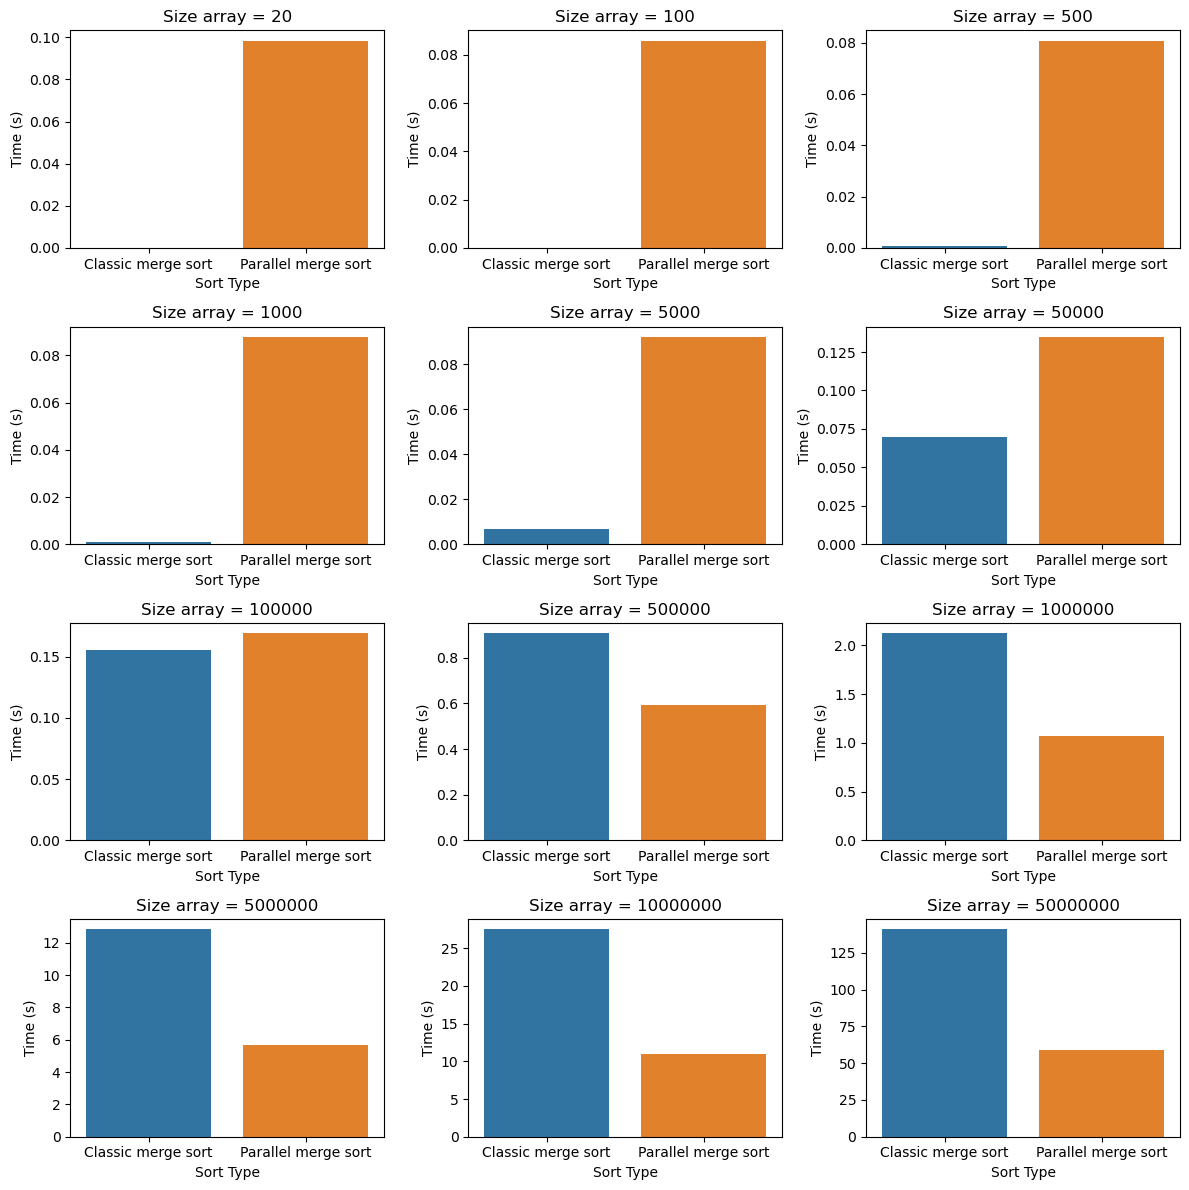

In [12]:
fig, axes = plt.subplots(4, 3, figsize=(12, 12))

index = 0
for i in range(4):
    for j in range(3):
        sns.barplot(y=all_time[index], x=x, ax=axes[i][j])
        axes[i][j].set_title(f'Size array = {size[index]}')
        axes[i][j].set_xlabel('Sort Type')
        axes[i][j].set_ylabel('Time (s)')
        index += 1
        if index == 12:
            break

axes[3][1].set_title(f'Size array = 10000000')
axes[3][1].set_xlabel('Sort Type')
axes[3][1].set_ylabel('Time (s)')


plt.tight_layout()

In [11]:
fig.savefig('report.jpg')